In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import timeit
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name=None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name

    def sample(self, N):
        x = self.coords[0:1, :] + (self.coords[1:2, :] - self.coords[0:1, :]) * np.random.uniform(0, 1, size=(N, self.dim))
        y = self.func(x)
        return x, y

class DataSampler:
    # Initialize the class
    def __init__(self, X, Y, name = None):
        self.X = X
        self.Y = Y
        self.N = self.X.shape[0]

    def sample(self, batch_size):
        idx = np.random.choice(self.N, batch_size, replace=True)
        X_batch = self.X[idx, :]
        Y_batch = self.Y[idx, :]
        return X_batch, Y_batch

In [ ]:
class Stefan1D_2P_inverse_I:

    def __init__(self, layers_u, layers_s, ics_sampler, ft1_sampler, res_sampler):
        X, _ = res_sampler.sample(np.int32(1e5))
        self.mu_X, self.sigma_X = X.mean(0), X.std(0)
        self.mu_x, self.sigma_x = self.mu_X[0], self.sigma_X[0]
        self.mu_t, self.sigma_t = self.mu_X[1], self.sigma_X[1]

        # Samplers
        self.ics_sampler = ics_sampler
        self.ft1_sampler = ft1_sampler
        self.res_sampler = res_sampler

        # Initialize network weights and biases
        self.layers_u = layers_u
        self.weights_u, self.biases_u = self.initialize_NN(layers_u)
        self.layers_s = layers_s
        self.weights_s, self.biases_s = self.initialize_NN(layers_s)

        # Define Tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

        # --- Define placeholders ---
        self.x_u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_u_tf = tf.placeholder(tf.float32, shape=(None, 1))

        # Initial conditions
        self.x1_ic_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t1_ic_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u1_ic_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x2_ic_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t2_ic_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u2_ic_tf = tf.placeholder(tf.float32, shape=(None, 1))

        # Final Time condition
        self.x1_T_tf = tf.placeholder(tf.float32, shape=(None, 1)) # Keep phase 1
        self.t1_T_tf = tf.placeholder(tf.float32, shape=(None, 1)) # Keep phase 1
        self.u1_T_tf = tf.placeholder(tf.float32, shape=(None, 1)) # Keep phase 1

        # Residual points
        self.x_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_r_tf = tf.placeholder(tf.float32, shape=(None, 1))

        # --- Evaluate predictions ---
        self.s_pred = self.net_s(self.t_u_tf)
        self.u1_pred, self.u2_pred = self.net_u1u2(self.x_r_tf, self.t_r_tf)
        self.u_pred = self.net_u(self.x_u_tf, self.t_u_tf)

        # Initial condition predictions
        self.u1_0_pred, _ = self.net_u1u2(self.x1_ic_tf, self.t1_ic_tf)
        _, self.u2_0_pred = self.net_u1u2(self.x2_ic_tf, self.t2_ic_tf)

        # Final time predictions
        self.u1_T_pred, _ = self.net_u1u2(self.x1_T_tf, self.t1_T_tf) # Keep phase 1 prediction

        # Interface predictions
        self.s_bc1_pred, self.s_bc2_pred = self.net_u1u2((self.net_s(self.t_r_tf) - self.mu_x) / self.sigma_x, self.t_r_tf)
        self.r_u1_pred, self.r_u2_pred = self.net_r_u1u2(self.x_r_tf, self.t_r_tf)
        self.r_Nc_pred = self.net_r_Nc(self.t_r_tf)

        # --- Loss Functions ---
        # Final Time Loss - ONLY for phase 1
        self.loss_u1_T = tf.reduce_mean(tf.square(self.u1_T_pred - self.u1_T_tf))
        self.loss_u_T = self.loss_u1_T

        # Initial Loss
        self.loss_u1_ic = tf.reduce_mean(tf.square(self.u1_0_pred - self.u1_ic_tf))
        self.loss_u2_ic = tf.reduce_mean(tf.square(self.u2_0_pred - self.u2_ic_tf))
        self.loss_u_ics = self.loss_u1_ic + self.loss_u2_ic

        # Stefan loss
        self.loss_Sbc1 = tf.reduce_mean(tf.square(self.s_bc1_pred))
        self.loss_Sbc2 = tf.reduce_mean(tf.square(self.s_bc2_pred))
        self.loss_s_0 = tf.reduce_mean(tf.square(self.net_s(self.t1_ic_tf) - 0.5))
        self.loss_SNc = tf.reduce_mean(tf.square(self.r_Nc_pred))
        self.loss_Scs = self.loss_Sbc1 + self.loss_Sbc2 + self.loss_s_0 + self.loss_SNc

        # Residual loss
        self.loss_res_u1 = tf.reduce_mean(tf.square(self.r_u1_pred))
        self.loss_res_u2 = tf.reduce_mean(tf.square(self.r_u2_pred))
        self.loss_res = self.loss_res_u1 + self.loss_res_u2

        # Total loss
        self.loss_u = self.loss_u_ics + self.loss_u_T
        self.loss = self.loss_res + self.loss_u + self.loss_Scs

        # Define optimizer
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-3
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,
                                                        1000, 0.9, staircase=False)
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)

        # Logging and Saving
        self.loss_total_log = []
        self.loss_u_log = []
        self.loss_Scs_log = []
        self.loss_res_log = []
        self.saver = tf.train.Saver()

        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

    # Xavier initialization
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
        return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,
                           dtype=tf.float32)

    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    # Evaluates the forward pass
    def forward_pass(self, H, weights, biases):
        num_layers = len(weights)
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H

     # Forward pass for u1, u2
    def net_u1u2(self, x, t):
        u = self.forward_pass(tf.concat([x, t], 1), self.weights_u, self.biases_u)
        u1 = u[:,0:1]
        u2 = u[:,1:2]
        return u1, u2

    def net_u1u2_x(self, x, t):
        u1, u2 = self.net_u1u2(x, t)
        u1_x = tf.gradients(u1, x)[0] / self.sigma_x
        u2_x = tf.gradients(u2, x)[0] / self.sigma_x

        return u1_x, u2_x

     # Forward pass for s
    def net_s(self, t):
        s = self.forward_pass(t, self.weights_s, self.biases_s)
        return s

     # Forward pass for u
    def net_u(self, x, t):
        u1, u2 = self.net_u1u2(x, t)
        s = self.net_s(t)  # consider normalization

        # demoralizing x coordinates
        x_hat = x * self.sigma_x + self.mu_x
        # consider s = x_hat
        u = tf.multiply(u1, 0.5 * (tf.sign(s - x_hat) + 1)) + tf.multiply(u2, 0.5 * (tf.sign(x_hat - s) + 1))
        return u

    # Forward pass for residual
    def net_r_u1u2(self, x, t):
        u1, u2 = self.net_u1u2(x, t)

        u1_t = tf.gradients(u1, t)[0] / self.sigma_t
        u1_x = tf.gradients(u1, x)[0] / self.sigma_x
        u1_xx = tf.gradients(u1_x, x)[0] / self.sigma_x
        r_u1 = u1_t - 2 * u1_xx

        u2_t = tf.gradients(u2, t)[0] / self.sigma_t
        u2_x = tf.gradients(u2, x)[0] / self.sigma_x
        u2_xx = tf.gradients(u2_x, x)[0] / self.sigma_x
        r_u2 = u2_t - u2_xx

        return r_u1, r_u2

    def net_r_Nc(self, t):
        s = self.net_s(t)
        s_t = tf.gradients(s, t)[0] / self.sigma_t

        # Normalizing s
        s = (s - self.mu_x) / self.sigma_x

        u1_x, u2_x = self.net_u1u2_x(s, t)
        residual = s_t - u2_x + 2 * u1_x
        return residual

    def fetch_minibatch(self, sampler, N):
        X, Y = sampler.sample(N)
        X = (X - self.mu_X) / self.sigma_X
        return X, Y

    def train(self, nIter=10000, batch_size=128):
        start_time = timeit.default_timer()

        for it in range(nIter):
            # Fetch initial condition and residual batches
            X1_ic_batch, u1_ic_batch = self.fetch_minibatch(self.ics_sampler[0], batch_size)
            X2_ic_batch, u2_ic_batch = self.fetch_minibatch(self.ics_sampler[1], batch_size)
            X_res_batch, _ = self.fetch_minibatch(self.res_sampler, batch_size)

            # Fetch final time condition batch (ONLY for phase 1)
            X1_T_batch, u1_T_batch = self.fetch_minibatch(self.ft1_sampler, batch_size)

            # Define a dictionary for associating placeholders with data
            tf_dict = {self.x_u_tf: X_res_batch[:, 0:1], self.t_u_tf: X_res_batch[:, 1:2],
                       # Initial conditions
                       self.x1_ic_tf: X1_ic_batch[:, 0:1], self.t1_ic_tf: X1_ic_batch[:, 1:2],
                       self.u1_ic_tf: u1_ic_batch,
                       self.x2_ic_tf: X2_ic_batch[:, 0:1], self.t2_ic_tf: X2_ic_batch[:, 1:2],
                       self.u2_ic_tf: u2_ic_batch,
                       # Final time conditions
                       self.x1_T_tf: X1_T_batch[:, 0:1], self.t1_T_tf: X1_T_batch[:, 1:2],
                       self.u1_T_tf: u1_T_batch,
                       # Residual points
                       self.x_r_tf: X_res_batch[:, 0:1], self.t_r_tf: X_res_batch[:, 1:2]}

            self.sess.run(self.train_op, tf_dict)

            # Print/Log
            if it % 10 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_u_value, loss_Scs_value, loss_res_value = self.sess.run(
                    [self.loss_u, self.loss_Scs, self.loss_res], tf_dict)

                self.loss_total_log.append(loss_value)
                self.loss_u_log.append(loss_u_value)
                self.loss_Scs_log.append(loss_Scs_value)
                self.loss_res_log.append(loss_res_value)
                print('It: %d, Loss: %.3e, Loss_u: %.3e, Loss_Scs: %.3e, Loss_res: %.3e, Time: %.2f' %
                      (it, loss_value, loss_u_value, loss_Scs_value, loss_res_value, elapsed))
                start_time = timeit.default_timer()

    # --- predict_u and predict_s  ---
    def predict_u(self, X_star):
         X_star = (X_star - self.mu_X) / self.sigma_X
         tf_dict = {self.x_u_tf: X_star[:, 0:1], self.t_u_tf: X_star[:, 1:2]}
         u_star = self.sess.run(self.u_pred, tf_dict)
         return u_star

    def predict_s(self, X_star):
         X_star = (X_star - self.mu_X) / self.sigma_X
         tf_dict = {self.t_u_tf: X_star[:, 1:2]}
         s_star = self.sess.run(self.s_pred, tf_dict)
         return s_star

In [ ]:
if __name__ == '__main__':

    # Exact u1
    def u1(x):
        t = x[:, 1:2]; x = x[:, 0:1]
        u1 = 2 * (np.exp((t + 0.5 - x) / 2) - 1)
        return u1

    # Exact u2
    def u2(x):
        t = x[:, 1:2]; x = x[:, 0:1]
        u2 = np.exp(t + 0.5 - x) - 1
        return u2

    # Exact s
    def s(x):
        t = x[:, 1:2]
        s = t + 0.5
        return s

    # Exact u
    def u(x):
        return np.where(x[:, 0:1] <= s(x), u1(x), u2(x))

    # Condition at the final time
    def u1_T(x):
        x = x[:, 0:1]
        u1_T = 2 * (np.exp((1 + 0.5 - x) / 2) - 1)
        return u1_T

    # Initial condition for s
    def s_0(x):
        z = 0.5; N = x.shape[0]
        return z * np.ones((N, 1))

    # Initial condition for u1
    def u1_0(x):
        x = x[:, 0:1]
        u1_0 = 2 * (np.exp((0.5 - x) / 2) - 1)
        return u1_0

    # Initial condition for u2
    def u2_0(x):
        x = x[:, 0:1]
        u2 = np.exp(0.5 - x) - 1
        return u2

    # Domain boundaries
    ics_coords = np.array([[0.0, 0.0], [2.0, 0.0]])
    ft_coords = np.array([[0.0, 1.0], [2.0, 1.0]])
    dom_coords = np.array([[0.0, 0.0], [2.0, 1.0]])

    # Initial Condition Samplers
    ic1_sampler = Sampler(2, ics_coords, lambda x: u1_0(x), name='Initial Condition 1')
    ic2_sampler = Sampler(2, ics_coords, lambda x: u2_0(x), name='Initial Condition 2')
    ics_sampler = [ic1_sampler, ic2_sampler]

    # Final Time Condition Sampler
    ft1_sampler = Sampler(2, ft_coords, lambda x: u1_T(x), name='Final Time Condition 1')

    # Create residual sampler
    res_sampler = Sampler(2, dom_coords, lambda x: u(x), name='Forcing')

    # Define model layers
    layers_u = [2, 100, 100, 100, 2]
    layers_s = [1, 100, 100, 100, 1]

    # Instantiate the model - Pass only ft1_sampler
    model = Stefan1D_2P_inverse_I(layers_u,
                                  layers_s,
                                  ics_sampler,
                                  ft1_sampler,
                                  res_sampler)

    # Train the model
    model.train(nIter=40000, batch_size=128)

    # Test data
    nn = 100
    x = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
    t = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
    X, T = np.meshgrid(x, t)
    X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

    u_star = u(X_star)
    s_star = s(X_star)

    # Predictions
    u_pred = model.predict_u(X_star)
    s_pred = model.predict_s(X_star)

    # Errors
    error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    error_s = np.linalg.norm(s_star - s_pred, 2) / np.linalg.norm(s_star, 2)

    print('Relative L2 error_u: {:.2e}'.format(error_u))
    print('Relative L2 error_s: {:.2e}'.format(error_s))

Device mapping: no known devices.
It: 0, Loss: 1.703e+00, Loss_u: 1.304e+00, Loss_Scs: 3.303e-01, Loss_res: 6.875e-02, Time: 0.78
It: 10, Loss: 1.234e+00, Loss_u: 9.546e-01, Loss_Scs: 2.104e-01, Loss_res: 6.874e-02, Time: 0.10
It: 20, Loss: 8.439e-01, Loss_u: 6.133e-01, Loss_Scs: 1.000e-01, Loss_res: 1.306e-01, Time: 0.11
It: 30, Loss: 8.687e-01, Loss_u: 4.847e-01, Loss_Scs: 8.168e-02, Loss_res: 3.024e-01, Time: 0.10
It: 40, Loss: 7.183e-01, Loss_u: 4.733e-01, Loss_Scs: 6.967e-02, Loss_res: 1.753e-01, Time: 0.11
It: 50, Loss: 5.878e-01, Loss_u: 3.883e-01, Loss_Scs: 7.383e-02, Loss_res: 1.257e-01, Time: 0.12
It: 60, Loss: 5.739e-01, Loss_u: 3.916e-01, Loss_Scs: 6.190e-02, Loss_res: 1.205e-01, Time: 0.12
It: 70, Loss: 4.997e-01, Loss_u: 3.106e-01, Loss_Scs: 6.011e-02, Loss_res: 1.290e-01, Time: 0.11
It: 80, Loss: 4.993e-01, Loss_u: 3.248e-01, Loss_Scs: 5.810e-02, Loss_res: 1.164e-01, Time: 0.10
It: 90, Loss: 4.739e-01, Loss_u: 3.033e-01, Loss_Scs: 5.359e-02, Loss_res: 1.171e-01, Time: 0.

In [ ]:
model.loss_total_log[-1]

np.float32(5.565135e-06)

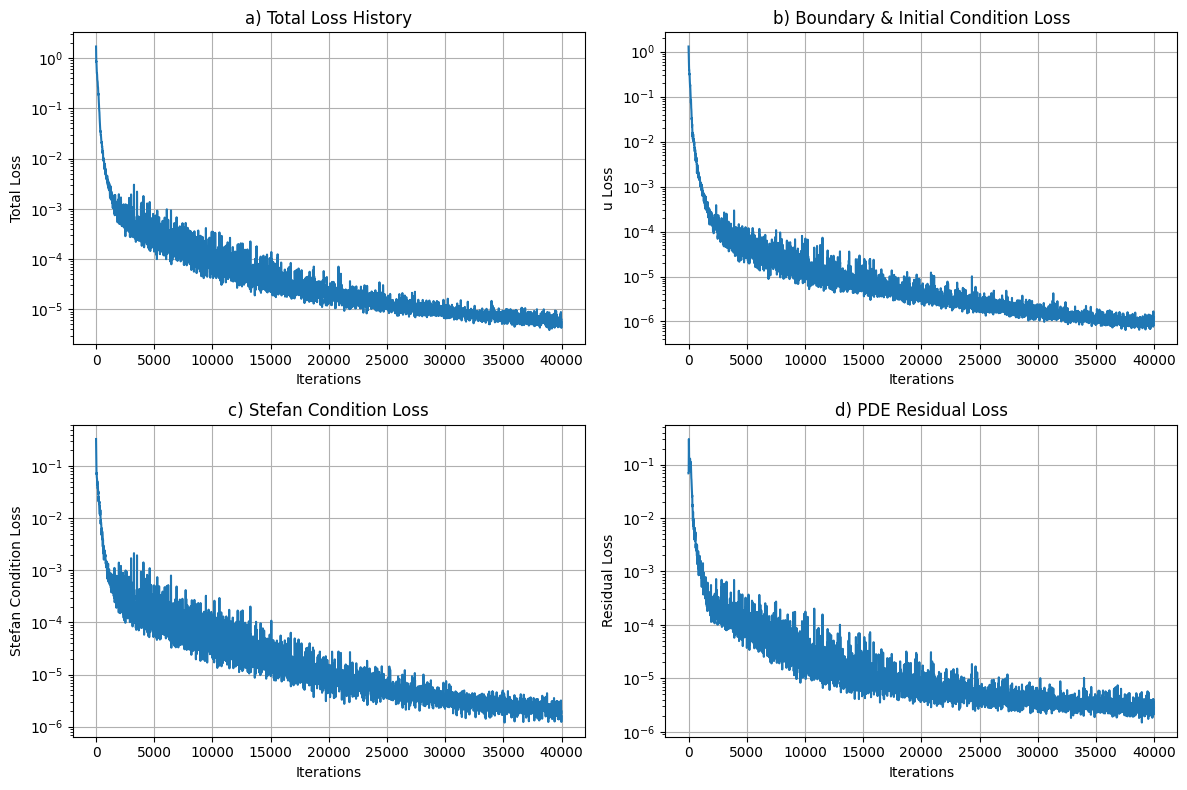

In [ ]:
fig = plt.figure(figsize=(12, 8))
iterations = np.arange(0, len(model.loss_total_log)) * 10  # Every 10 iterations

# Subplot 1
plt.subplot(2, 2, 1)
plt.semilogy(iterations, model.loss_total_log)
plt.xlabel('Iterations')
plt.ylabel('Total Loss')
plt.title('a) Total Loss History')
plt.grid(True)

# Subplot 2
plt.subplot(2, 2, 2)
plt.semilogy(iterations, model.loss_u_log)
plt.xlabel('Iterations')
plt.ylabel('u Loss')
plt.title('b) Boundary & Initial Condition Loss')
plt.grid(True)

# Subplot 3
plt.subplot(2, 2, 3)
plt.semilogy(iterations, model.loss_Scs_log)
plt.xlabel('Iterations')
plt.ylabel('Stefan Condition Loss')
plt.title('c) Stefan Condition Loss')
plt.grid(True)

# Subplot 4
plt.subplot(2, 2, 4)
plt.semilogy(iterations, model.loss_res_log)
plt.xlabel('Iterations')
plt.ylabel('Residual Loss')
plt.title('d) PDE Residual Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

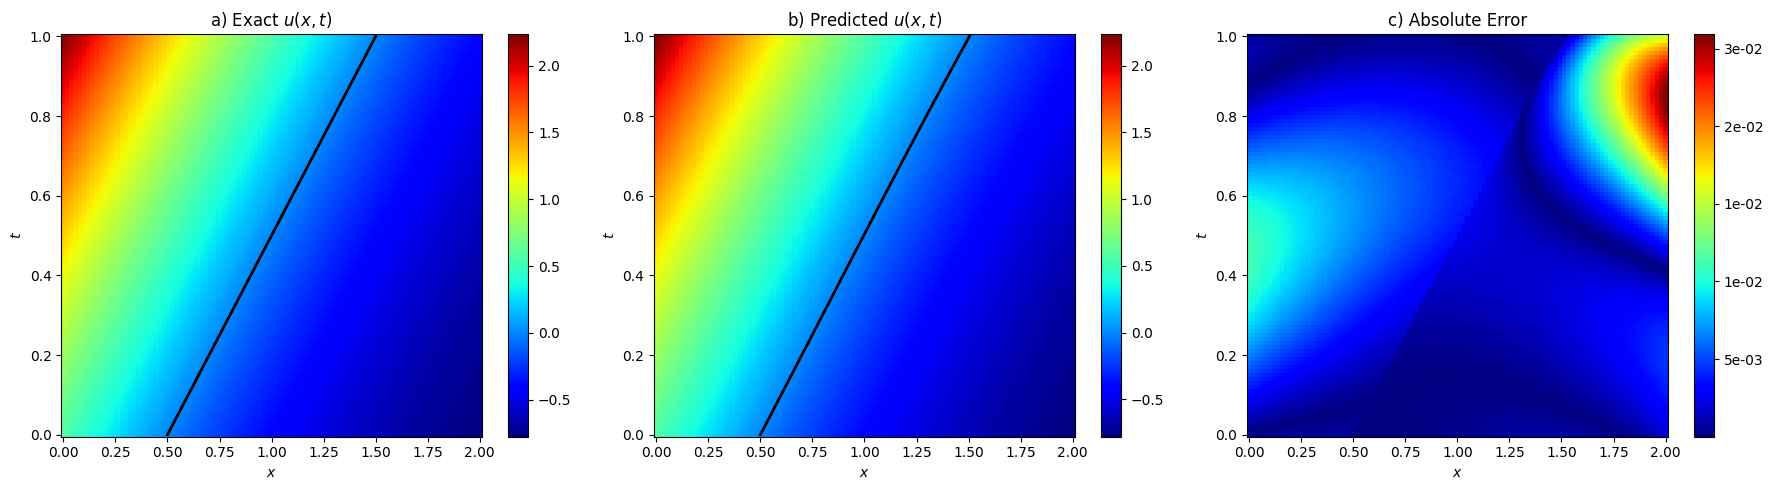

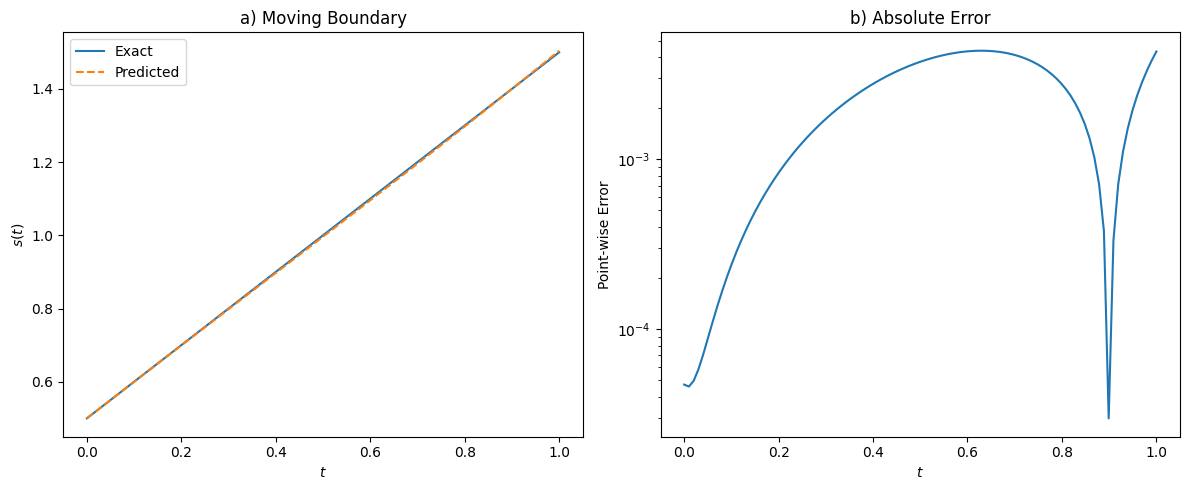

In [ ]:
    U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')
    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

    t = np.linspace(0, 1, 100)[:, None]
    x = np.zeros_like(t)
    x_star = np.concatenate((x, t), axis=1)
    s_star = s(x_star)
    s_pred = model.predict_s(x_star)
    error_s = np.abs(s_star - s_pred)

    # Plot for solution u
    fig_1 = plt.figure(1, figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.plot(s_star, t, color='black', linewidth=2)
    plt.pcolor(X, T, U_star, cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x$')
    plt.ylabel(r'$t$')
    plt.title('a) Exact $u(x,t)$')

    plt.subplot(1, 3, 2)
    plt.pcolor(X, T, U_pred, cmap='jet')
    plt.plot(s_pred, t, color='black', linewidth=2)
    plt.colorbar()
    plt.xlabel(r'$x$')
    plt.ylabel(r'$t$')
    plt.title('b) Predicted $u(x,t)$')

    plt.subplot(1, 3, 3)
    plt.pcolor(X, T, np.abs(U_star - U_pred), cmap='jet')
    plt.colorbar(format='%.0e')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$t$')
    plt.title('c) Absolute Error')

    plt.tight_layout()
    plt.show()

    # Plot for solution s
    fig_2 = plt.figure(2, figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(t, s_star, label='Exact')
    plt.plot(t, s_pred, '--', label='Predicted')
    plt.xlabel(r'$t$')
    plt.ylabel(r'$s(t)$')
    plt.title('a) Moving Boundary')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(t, error_s)
    plt.xlabel(r'$t$')
    plt.ylabel(r'Point-wise Error')
    plt.title('b) Absolute Error')
    plt.yscale('log')

    plt.tight_layout()
    plt.show()